In [140]:
import seaborn as sns
import pandas as pd
from ctgan import CTGAN
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import torch

In [141]:
iris_data = sns.load_dataset("iris")
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [142]:
ctgan = CTGAN(epochs=2500, verbose=True)
# ctgan.fit(iris_data, ["species"])
ctgan.fit(iris_data.drop(["species"], axis=1))


Gen. (-0.64) | Discrim. (-0.14): 100%|██████████| 2500/2500 [00:24<00:00, 102.86it/s]


<Axes: ylabel='Generator Loss'>

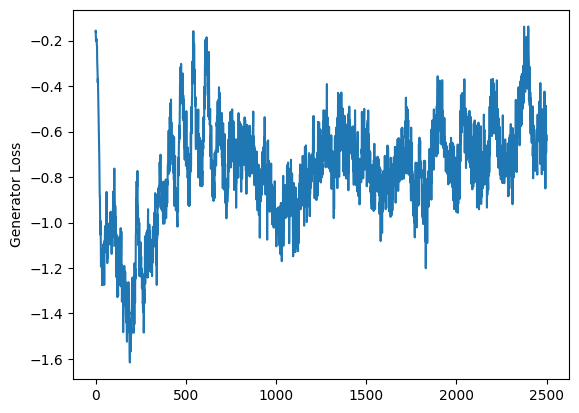

In [143]:
sns.lineplot(ctgan.loss_values["Generator Loss"])


<Axes: ylabel='Discriminator Loss'>

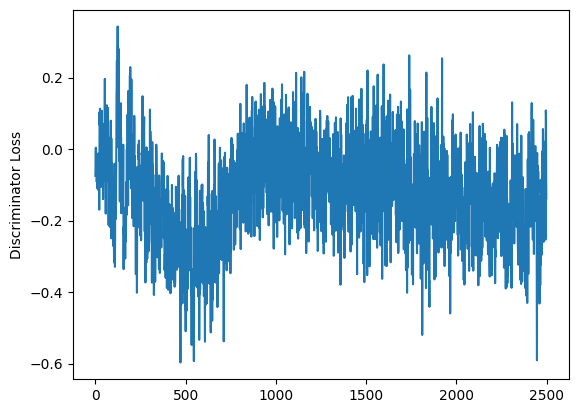

In [144]:
sns.lineplot(ctgan.loss_values["Discriminator Loss"])


In [4]:
ctgan._discriminator

Discriminator(
  (seq): Sequential(
    (0): Linear(in_features=130, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [19]:
list(list(ctgan._discriminator.children())[0].children())[-3]

LeakyReLU(negative_slope=0.2)

/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_4414/1771519020.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),


<Axes: >

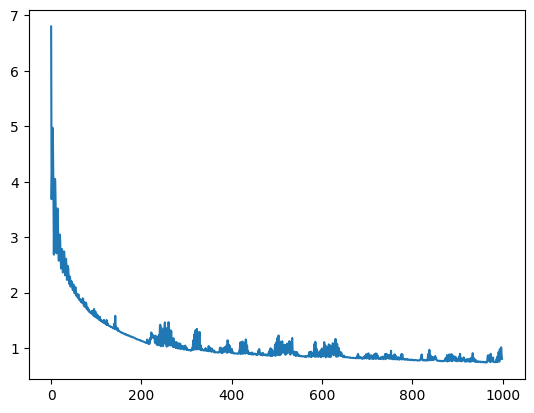

In [ ]:
import torch.nn.functional as F

def vec_to_df(vec):
    return pd.DataFrame({
        "sepal_length": [vec[0]],
        "sepal_width": [vec[1]],
        "petal_length": [vec[2]],
        "petal_width": [vec[3]],
        
    })

def detect_anomaly(vec):
    ctgan._generator.eval()
    ctgan._discriminator.eval()

    mean = torch.zeros(2, ctgan._embedding_dim)
    std = mean + 1
    z = torch.normal(mean=mean, std=std).to(ctgan._device)
    z.requires_grad = True
    optimizer = torch.optim.Adam([z], lr=1 * 1e-2)
    # print(z.shape)

    features_real = {}
    features_fake = {}

    feats_hist = []

    def hook_real(module, input, output):
        features_real['feat'] = output
        feats_hist.append(output)

    def hook_fake(module, input, output):
        features_fake['feat'] = output
        feats_hist.append(output)

    # Attach hooks to a middle layer in D (assumes sequential model)
    layer = list(list(ctgan._discriminator.children())[0].children())[-3]  # adjust depending on your D architecture
    handle_real = layer.register_forward_hook(hook_real)
    # handle_fake = layer.register_forward_hook(hook_fake)

    vec_transformed = ctgan._transformer.transform(vec_to_df(vec))
    # print(torch.tensor([vec_transformed]).shape)

    vec_transformed_vectorized = torch.cat([
        torch.tensor([vec_transformed]),
    ]*10)
    vec_transformed_vectorized_single = torch.tensor(vec_transformed[0,:])

    # print(vec_transformed_vectorized_single)

    res_losses_hist = []
    loss_hist = []

    STEPS = 1000
    for i in range(STEPS):
        optimizer.zero_grad()

        # print("--=-=-", z)
        fake = ctgan._generator(z)
        # print("--=-=-", fake)
        # return
        fakeact = ctgan._apply_activate(fake)

        fake_vectorized = torch.cat([
            torch.tensor(fakeact),
        ]*10)

        # print(fakeact)

        ctgan._discriminator(vec_transformed_vectorized.type(torch.float))

        ctgan._discriminator(fake_vectorized.type(torch.float))
    
        # transformed = ctgan._transformer.inverse_transform(fakeact)


        # feature_loss = F.l1_loss(features_fake['feat'], features_real['feat'])
        feature_loss = F.l1_loss(feats_hist[-1][0,:10], feats_hist[-2][0,:10])
        

        # print(feature_loss)

        # residual_loss = F.l1_loss(torch.tensor(np.array(transformed)[0,:]), torch.tensor(vec))
        residual_loss = F.l1_loss(fake[0,:], vec_transformed_vectorized_single)

        # print("AAAA", len(feats_hist), features_fake['feat'], "\nBBB", features_real['feat'])

        # print("AAAA", len(feats_hist), feats_hist[-1], "\nBBB",  feats_hist[-2])

        # print(residual_loss)

        # Total loss
        loss = residual_loss + 0.1 * feature_loss
        # print(f"Feature loss = {feature_loss.item()}, Residual loss = {residual_loss.item()}, Loss = {loss}")
        loss.backward()
        optimizer.step()

        feats_hist = []

        loss_hist.append(loss.item())

        # print(z[1,:10])

    return loss_hist[-1], loss_hist

ctgan._discriminator.pac = 1

score, losses = detect_anomaly(np.array([10000,100,3,-100]))
sns.lineplot(losses)

In [128]:
real_scores = []
for r in iris_data.iterrows():
    score, _ = detect_anomaly(np.array(r[1])[:-1])
    real_scores.append(score)
    if len(real_scores) >50:
        break

/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_4414/2008302263.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_4414/2008302263.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_4414/2008302263.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_4414/2008302263.py:65: UserWarni

In [131]:
fake_scores = []
for r in range(50):
    fake_vec = np.random.normal(0,1,(4)) * 20
    score, _ = detect_anomaly(fake_vec)
    fake_scores.append(score)
    # if len(fake_scores) >10:
    #     break
fake_scores

/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_4414/2008302263.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_4414/2008302263.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_4414/2008302263.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_4414/2008302263.py:65: UserWarni

[0.907194075750617,
 0.9505402157255479,
 0.9887555593366807,
 0.9298389408622797,
 0.8300617277009807,
 1.0389616239414765,
 0.8533494661087965,
 0.8425620226371098,
 1.082573460632792,
 0.9701812594727829,
 0.9328739659961027,
 1.15820816911757,
 0.9569590669529499,
 1.009227250454804,
 1.0700268548440475,
 1.0158217502786564,
 0.981074035600401,
 1.086690086802611,
 0.952489368880096,
 0.8924968456878113,
 1.0819787934021308,
 1.037848810242478,
 1.183522512794558,
 1.0633628697234851,
 0.7282163839709404,
 0.9726679805838145,
 0.8211496448029693,
 1.1496728023256249,
 0.9561912700419243,
 1.0744841990734524,
 1.06549634555498,
 0.9956162209165947,
 0.854173613643417,
 1.0799856150838045,
 1.0319813754240295,
 0.9038913709211809,
 1.033526493525849,
 0.9176694410153574,
 0.8336971607024289,
 0.8871507149648209,
 1.0205170376828083,
 1.0813502648587412,
 1.243219356342004,
 0.9938048625823398,
 0.9341107102211279,
 0.9551787380372676,
 0.9494469341349144,
 1.0017056772111057,
 1.3002

<Axes: >

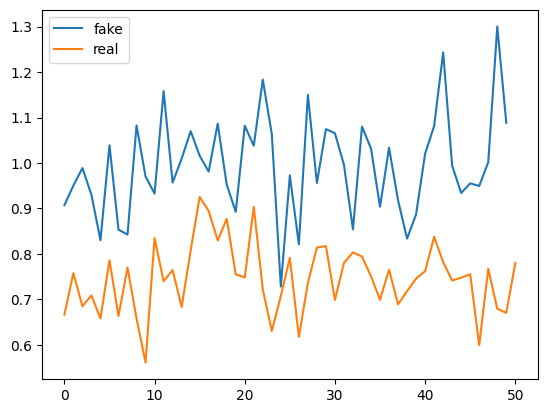

In [132]:
sns.lineplot(fake_scores, label="fake")
sns.lineplot(real_scores, label="real")

/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_4414/1771519020.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_4414/1771519020.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),


<Axes: >

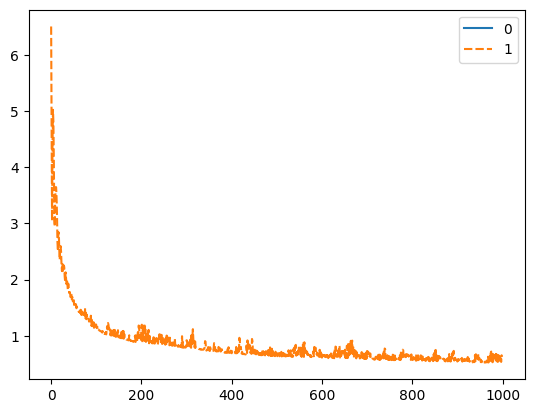

In [135]:
detect_anomaly(np.array([5.927839,	3.462155,	2.179409,	0.402681]))
losses = detect_anomaly(np.array([5.927839,	3.462155,	2.179409,	0.402681]))
sns.lineplot(losses)

In [9]:
synthetic_iris = ctgan.sample(1000)
synthetic_iris.head(20)

,sepal_length,sepal_width,petal_length,petal_width
0,5.927839,3.462155,2.179409,0.402681
1,5.334049,2.804819,1.247269,0.212128
2,6.831077,3.145618,4.169469,1.724423
3,6.411891,3.323011,5.489717,1.872817
4,6.288063,3.036851,5.331102,1.691200
5,5.768422,2.886213,3.571111,1.733648
6,5.017273,2.816972,0.739379,0.076833
7,5.186913,2.849859,4.952274,0.360297
8,5.934587,2.824164,4.991485,1.527647
9,5.138508,3.094046,0.991174,0.185066


In [20]:

def tsne_plot(x1, y1):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(8, 4))

    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Real')
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Generated')

    plt.scatter(X_t[np.where(y1 == 2), 0], X_t[np.where(y1 == 2), 1], marker='o', color='b', linewidth=1, alpha=0.8, label='Anomaly')

    plt.legend(loc='best')
    plt.show()


In [11]:
real_data = np.array(iris_data.drop(["species"], axis=1))
# gen_data = np.array(synthetic_iris.drop(["species"], axis=1))
gen_data = np.array(synthetic_iris)


In [12]:
np.vstack([real_data, gen_data]).shape

(1150, 4)

In [24]:
anomaly_data.shape

(1, 4)

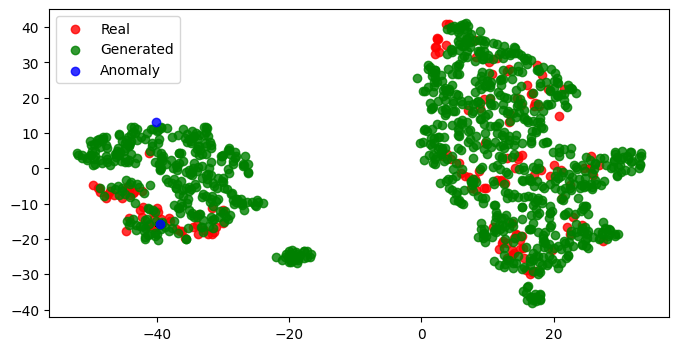

In [31]:
gen_data1 = torch.zeros((0,11))
real_data1 = torch.zeros((0,11))

anomaly_data = np.array([[20,100,100,-10000]])

tsne_plot(
    np.array( np.vstack([real_data, gen_data, anomaly_data]) ),
    torch.cat(  [torch.ones((real_data.shape[0],1)), torch.zeros((gen_data.shape[0],1)), torch.ones((anomaly_data.shape[0],1)) + 1]  )
)

In [171]:
torch.rand((5,100))


tensor([[0.6927, 0.9082, 0.5525, 0.7103, 0.9933, 0.2330, 0.9083, 0.5535, 0.5771,
         0.4294, 0.3342, 0.6753, 0.2219, 0.6622, 0.9739, 0.1368, 0.5041, 0.5366,
         0.8047, 0.3186, 0.0019, 0.1431, 0.4980, 0.5679, 0.5085, 0.9856, 0.1458,
         0.9914, 0.7500, 0.6777, 0.7638, 0.9968, 0.0719, 0.6645, 0.8094, 0.4623,
         0.7855, 0.5021, 0.9190, 0.0103, 0.4512, 0.0652, 0.6663, 0.7066, 0.9218,
         0.2025, 0.2720, 0.0085, 0.0797, 0.8195, 0.3908, 0.9673, 0.0624, 0.5320,
         0.8330, 0.9062, 0.1487, 0.4310, 0.9728, 0.5216, 0.6040, 0.1733, 0.7465,
         0.3017, 0.4199, 0.8418, 0.6582, 0.5059, 0.9239, 0.5436, 0.4274, 0.7505,
         0.4677, 0.9968, 0.2214, 0.7469, 0.1636, 0.8189, 0.1949, 0.6459, 0.5026,
         0.8979, 0.5670, 0.3410, 0.4682, 0.8491, 0.5913, 0.2373, 0.6769, 0.3008,
         0.1693, 0.5743, 0.0658, 0.6555, 0.7302, 0.6734, 0.2513, 0.3253, 0.7772,
         0.2107],
        [0.6297, 0.7792, 0.8897, 0.5032, 0.6284, 0.4032, 0.4826, 0.1236, 0.6144,
         0

In [173]:
a = torch.rand((5,100))
b = torch.rand((100,7))
# a[0][1] = 12

# b[0][0] = 12

a_norms = torch.sqrt((a**2).sum(axis=1))
b_norms = torch.sqrt((b**2).sum(axis=0))

a_norms, b_norms

(tensor([6.2314, 5.6533, 5.5210, 5.6585, 5.7865]),
 tensor([5.5370, 5.8288, 5.9156, 5.8959, 6.1102, 5.3263, 5.8790]))

In [174]:
(a @ b) / torch.stack([a_norms] * 7).T / torch.stack([b_norms] * 5)

tensor([[0.7525, 0.7613, 0.7444, 0.8244, 0.8203, 0.7712, 0.7813],
        [0.7595, 0.7698, 0.7296, 0.7598, 0.7910, 0.7277, 0.7890],
        [0.7124, 0.7541, 0.7478, 0.7307, 0.7164, 0.6992, 0.7715],
        [0.7337, 0.7596, 0.7245, 0.7780, 0.8091, 0.7210, 0.7810],
        [0.7082, 0.7786, 0.7347, 0.7262, 0.7708, 0.6822, 0.7728]])

In [177]:
torch.nn.functional.cosine_similarity(a[-1,:], b[:,-1], dim=0)

tensor(0.7728)

In [166]:
a[1,:].shape, b[:,1].shape

(torch.Size([100]), torch.Size([100]))